In [1]:
import os
import requests


def download_files_from_github(repository_url, folder_path, file_extension='.py'):
    response = requests.get(f"{repository_url}/contents/{folder_path}")
    files = response.json()

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    for file in files:
        if file['type'] == 'file' and file['name'].endswith(file_extension):
            file_url = file['download_url']
            file_content = requests.get(file_url).text

            file_path = os.path.join(folder_path, file['name'])
            with open(file_path, 'w') as f:
                f.write(file_content)

            print(f"Downloaded: {file_path}")


if __name__ == "__main__":
    repository_url = "https://api.github.com/repos/Riwaj22/Pytorch"
    folder_path = "Going Modular"
    file_extension = ".py"

In [2]:
  download_files_from_github(repository_url, folder_path, file_extension)

Downloaded: Going Modular/data_setup.py
Downloaded: Going Modular/evaluation_utils.py
Downloaded: Going Modular/github_downloader.py
Downloaded: Going Modular/plotting_curves.py
Downloaded: Going Modular/prediction_on_uploaded_image.py
Downloaded: Going Modular/training_utils.py


In [3]:
import sys
sys.path.append('/content/Going Modular')

import evaluation_utils, plotting_curves, prediction_on_uploaded_image, training_utils, data_setup
from data_setup import *


Transfer Learning

Why use Transfer Learning:

1. Can leverage an existing neural network architecture proven to work on problems similar to our own.

2. Can leverage a working network architecture which has already learned pattterns on similar data to our own.


In [4]:
import torchvision
import torch

In [5]:
device = "cuda"

In [6]:
!pip install torchinfo

In [7]:
from tqdm import tqdm
from torchvision import datasets

GetData

In [8]:
from math import e
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path('data/')
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print("Skipping download")
else:
  print("Downloading")
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading data...")
  f.write(request.content)

# Unzip data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping data")
  zip_ref.extractall(image_path)


Downloading
Unzipping data


In [9]:

train_dir = image_path / "train"
test_dir = image_path / "test"

In [10]:
train_dir, test_dir


(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

data/pizza_steak_sushi/train/sushi/2980779.jpg
sushi
Random image path is data/pizza_steak_sushi/train/sushi/2980779.jpg
Image class: sushi
Image Height: 512
Image Width: 512


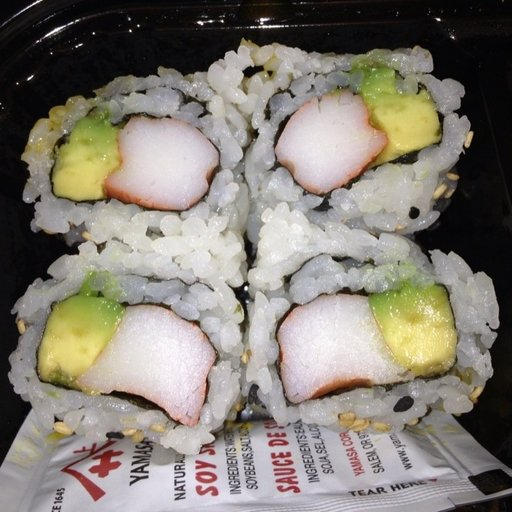

In [11]:

import random
from PIL import Image

# random.seed(42)
image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)
print(random_image_path)

# get image class from path name
image_class = random_image_path.parent.stem
print(image_class)

# Open image
img = Image.open(random_image_path)

# Print metadata
print(f"Random image path is {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image Height: {img.height}")
print(f"Image Width: {img.width}")
img

Creating a transforms fot torchvision.datasets

Automatic data transform creation based on pre trained models

get a set of pretrained model weights

In [12]:
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights


In [230]:
# model = efficientnet_b7(weights="DEFAULT")
weights = torchvision.models.EfficientNet_B7_Weights.DEFAULT
weights


EfficientNet_B7_Weights.IMAGENET1K_V1

In [388]:
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

# Define the get_state_dict function
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)

# Override the get_state_dict function in WeightsEnum
WeightsEnum.get_state_dict = get_state_dict

# Load EfficientNet-B7 with default (ImageNet) weights
model1 = efficientnet_b7(weights=EfficientNet_B7_Weights.DEFAULT)


Get the transfoms used in our pretransformed models

In [389]:
model1

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [393]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[600]
    resize_size=[600]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [394]:
train_dataloader, test_dataloader, class_names =  create_dataloaders(train_dir=train_dir,
                             test_dir=test_dir,
                             transform=auto_transforms,
                             batch_size=32,
                             num_workers=2)



In [395]:
train_dataloader

In [396]:
class_names

['pizza', 'steak', 'sushi']

Choosing a pretrained model

The whole idea of transfer learning takes an already well performing model from a problem space similar to our own and then customize to our own problem.

Three things to consider:
1. Speed
2. Size
3. Performance

Setting up a pre trained model

In [20]:
!pip install torchinfo
from torchinfo import summary

In [397]:
summary(model1, input_size =(1,3,224,224), col_names =["input_size","output_size","num_params","trainable"],
        row_settings = ["var_names"], col_width =20)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 2560, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 64, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 64, 112, 112]    1,728                True
│    │    └─BatchNorm2d (1)                                  [1, 64, 112, 112]    [1, 64, 112, 112]    128                  True
│    │    └─SiLU (2)                                         [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 64, 112, 112]    [1, 32, 112,

In [398]:
model1.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=True)
  (1): Linear(in_features=2560, out_features=1000, bias=True)
)

In [289]:
len(class_names)

3

Create an model

Freezing the base model and changing the output layers

In [399]:
for param in model1.features.parameters():

  param.requires_grad = False



In [400]:
from torchinfo import summary

# Assuming model1 is your PyTorch model
input_size = (1, 3, 224, 224)  # Assuming input size for your model
summary(model1, input_size=input_size, col_names=["input_size", "output_size", "num_params", "trainable"])


Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [1, 3, 224, 224]          [1, 1000]                 --                        Partial
├─Sequential: 1-1                                       [1, 3, 224, 224]          [1, 2560, 7, 7]           --                        False
│    └─Conv2dNormActivation: 2-1                        [1, 3, 224, 224]          [1, 64, 112, 112]         --                        False
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224]          [1, 64, 112, 112]         (1,728)                   False
│    │    └─BatchNorm2d: 3-2                            [1, 64, 112, 112]         [1, 64, 112, 112]         (128)                     False
│    │    └─SiLU: 3-3                                   [1, 64, 112, 112]         [1, 64, 112, 112]         --                        --
│    └─Sequential

In [401]:
model1.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=True)
  (1): Linear(in_features=2560, out_features=1000, bias=True)
)

In [402]:
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)
device="cuda"
model1.classifier = nn.Sequential(
    nn.Dropout(p= 0.2,inplace = True),
    nn.Linear(in_features= 2560,
              out_features = len(class_names)

              )
).to("cuda")

In [403]:
model1.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=2560, out_features=3, bias=True)
)

In [404]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr =0.001)

In [405]:

import requests
from pathlib import Path
url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"
if Path("helper_functions.py").is_file():
  print("Helper function already exists")
else:
  print("Downloading file")
  request = requests.get(url)
  with open("helper_function.py", "wb") as f:
    f.write(request.content)


In [406]:
from helper_function import accuracy_fn


In [407]:
from training_utils import *

In [408]:
import time

# Record start time
start_time = time.time()

# Your training code here
results = train(model=model1, train_data_loader=train_dataloader, test_data_loader=test_dataloader,
                optimizer=optimizer, loss_fn=loss_fn, accuracy_fn=accuracy_fn,
                epochs=25, early_stop_patience=3, device="cuda")

# Record end time
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
elapsed_time_minutes = elapsed_time / 60.0
print(f"Time taken: {elapsed_time_minutes:.2f} minutes")


  4%|▍         | 1/25 [00:24<09:57, 24.89s/it]

Epoch:1 | Train Loss:1.012 | Train Accuracy:0.644 | Test Loss: 0.801| Test accuracy:0.867


  8%|▊         | 2/25 [00:49<09:32, 24.91s/it]

Epoch:2 | Train Loss:0.815 | Train Accuracy:0.827 | Test Loss: 0.647| Test accuracy:0.867


 12%|█▏        | 3/25 [01:14<09:09, 24.99s/it]

Epoch:3 | Train Loss:0.693 | Train Accuracy:0.840 | Test Loss: 0.542| Test accuracy:0.920


 16%|█▌        | 4/25 [01:40<08:46, 25.06s/it]

Epoch:4 | Train Loss:0.596 | Train Accuracy:0.858 | Test Loss: 0.456| Test accuracy:0.920


 20%|██        | 5/25 [02:05<08:21, 25.05s/it]

Epoch:5 | Train Loss:0.498 | Train Accuracy:0.942 | Test Loss: 0.395| Test accuracy:0.947


 24%|██▍       | 6/25 [02:30<07:58, 25.16s/it]

Epoch:6 | Train Loss:0.463 | Train Accuracy:0.942 | Test Loss: 0.341| Test accuracy:0.947


 28%|██▊       | 7/25 [02:55<07:33, 25.21s/it]

Epoch:7 | Train Loss:0.399 | Train Accuracy:0.964 | Test Loss: 0.317| Test accuracy:0.960


 32%|███▏      | 8/25 [03:21<07:10, 25.35s/it]

Epoch:8 | Train Loss:0.376 | Train Accuracy:0.947 | Test Loss: 0.304| Test accuracy:0.947


 36%|███▌      | 9/25 [03:47<06:50, 25.63s/it]

Epoch:9 | Train Loss:0.359 | Train Accuracy:0.951 | Test Loss: 0.282| Test accuracy:0.947


 40%|████      | 10/25 [04:13<06:27, 25.83s/it]

Epoch:10 | Train Loss:0.321 | Train Accuracy:0.956 | Test Loss: 0.249| Test accuracy:0.960


 44%|████▍     | 11/25 [04:39<05:59, 25.69s/it]

Epoch:11 | Train Loss:0.317 | Train Accuracy:0.956 | Test Loss: 0.236| Test accuracy:0.960


 48%|████▊     | 12/25 [05:04<05:32, 25.58s/it]

Epoch:12 | Train Loss:0.302 | Train Accuracy:0.969 | Test Loss: 0.232| Test accuracy:0.960


 52%|█████▏    | 13/25 [05:30<05:08, 25.68s/it]

Epoch:13 | Train Loss:0.259 | Train Accuracy:0.978 | Test Loss: 0.231| Test accuracy:0.960


 56%|█████▌    | 14/25 [05:56<04:44, 25.91s/it]

Epoch:14 | Train Loss:0.277 | Train Accuracy:0.964 | Test Loss: 0.215| Test accuracy:0.960


 60%|██████    | 15/25 [06:22<04:19, 25.91s/it]

Epoch:15 | Train Loss:0.226 | Train Accuracy:0.978 | Test Loss: 0.210| Test accuracy:0.960


 64%|██████▍   | 16/25 [06:48<03:51, 25.77s/it]

Epoch:16 | Train Loss:0.228 | Train Accuracy:0.987 | Test Loss: 0.210| Test accuracy:0.960


 68%|██████▊   | 17/25 [07:13<03:25, 25.67s/it]

Epoch:17 | Train Loss:0.215 | Train Accuracy:0.982 | Test Loss: 0.205| Test accuracy:0.960


 72%|███████▏  | 18/25 [07:39<02:59, 25.64s/it]

Epoch:18 | Train Loss:0.218 | Train Accuracy:0.991 | Test Loss: 0.200| Test accuracy:0.960


 76%|███████▌  | 19/25 [08:04<02:33, 25.63s/it]

Epoch:19 | Train Loss:0.217 | Train Accuracy:0.964 | Test Loss: 0.197| Test accuracy:0.960


 80%|████████  | 20/25 [08:31<02:09, 25.82s/it]

Epoch:20 | Train Loss:0.170 | Train Accuracy:0.991 | Test Loss: 0.195| Test accuracy:0.973


 84%|████████▍ | 21/25 [08:57<01:44, 26.04s/it]

Epoch:21 | Train Loss:0.166 | Train Accuracy:0.991 | Test Loss: 0.200| Test accuracy:0.973


 88%|████████▊ | 22/25 [09:23<01:17, 25.92s/it]

Epoch:22 | Train Loss:0.187 | Train Accuracy:0.982 | Test Loss: 0.205| Test accuracy:0.973


 88%|████████▊ | 22/25 [09:49<01:20, 26.78s/it]

Epoch:23 | Train Loss:0.211 | Train Accuracy:0.956 | Test Loss: 0.205| Test accuracy:0.960
Early stopping at epoch 23 due to no improvement in test loss.
Time taken: 9.82 minutes


In [410]:
from evaluation_utils import *

In [411]:
labels = class_names
labels

['pizza', 'steak', 'sushi']

In [413]:
def evaluate_model(model, data_loader, loss_fn, accuracy_fn, custom_labels):
    model = model.to("cuda")

    loss, acc = 0, 0
    all_true_labels, all_predicted_labels = [], []

    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X = X.to("cuda")
            y = y.to("cuda")
            y_pred = model(X)

            loss += loss_fn(y_pred, y).detach()
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

            all_true_labels.extend(y.cpu().numpy())
            all_predicted_labels.extend(y_pred.argmax(dim=1).cpu().numpy())

        loss /= len(data_loader)
        acc /= len(data_loader)

    precision, recall, f1, _ = precision_recall_fscore_support(
        all_true_labels, all_predicted_labels, average='macro', zero_division=0
    )

    conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

    result = {
        "model_name": model.__class__.__name__,
        "model_loss": loss.item(),
        "model_acc": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": conf_matrix
    }

    plot_confusion_matrix(conf_matrix, custom_labels)

    return result


def plot_confusion_matrix(conf_matrix, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels,
                cbar=False, linewidths=.5, annot_kws={"size": 24}, square=True)

    for i in range(len(labels)):
        plt.text(i + 0.5, i + 0.5, f'{conf_matrix[i, i]}', ha='center', va='center', color='red', fontsize=24)

    plt.title('Confusion Matrix ')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


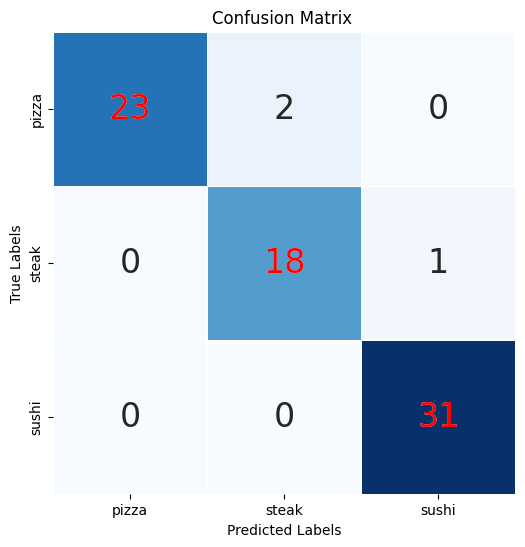

{'model_name': 'EfficientNet',
 'model_loss': 0.1978420615196228,
 'model_acc': 96.875,
 'precision': 0.9562499999999999,
 'recall': 0.9557894736842106,
 'f1': 0.9551790801790802,
 'confusion_matrix': array([[23,  2,  0],
        [ 0, 18,  1],
        [ 0,  0, 31]])}

In [414]:
evaluate_model(model1, test_dataloader, loss_fn, accuracy_fn, labels)

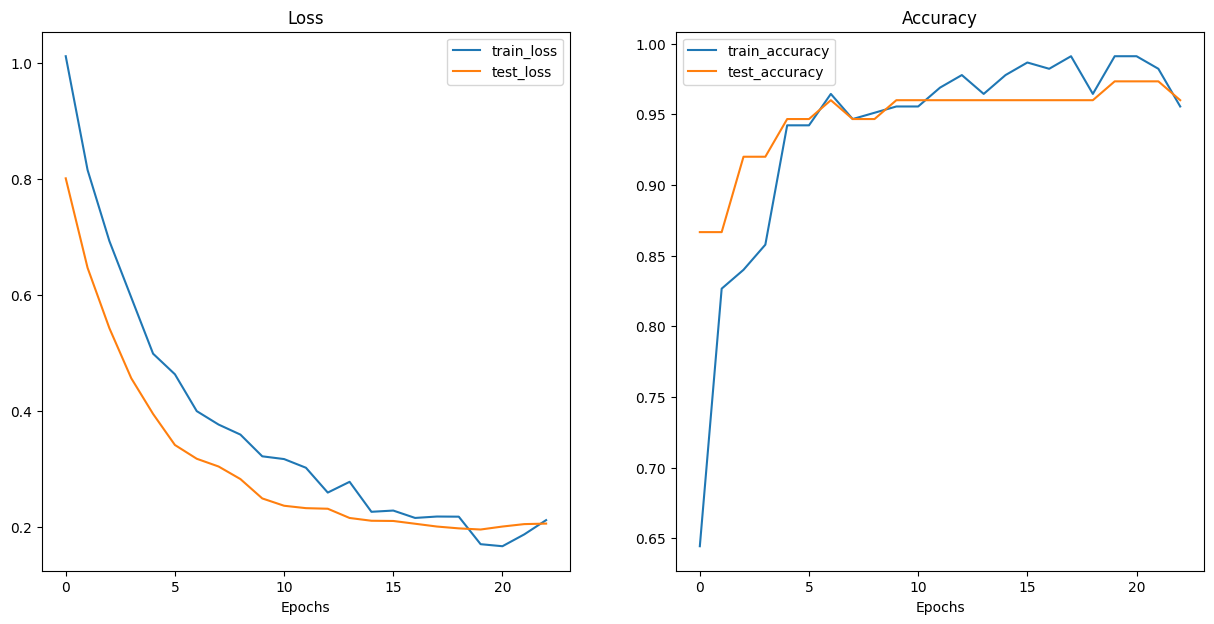

In [415]:
plot_curves(results= results)

In [305]:
from prediction_on_uploaded_image import *

In [418]:
import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
from torchvision import transforms
from PIL import Image
import ipywidgets as widgets
from IPython.display import display
from io import BytesIO

import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
from torchvision import transforms
from PIL import Image
import ipywidgets as widgets
from IPython.display import display
from io import BytesIO

class ImagePredictor:
    def __init__(self, model, custom_labels):
        self.model = model.to('cpu')
        self.custom_labels = custom_labels
        self.preprocess = auto_transforms

    def predict_image(self, upload_widget):
        # Get the uploaded image
        uploaded_image = upload_widget.data[-1]

        # Display the uploaded image
        display(Image.open(BytesIO(uploaded_image)))

        # Preprocess the image
        input_image = Image.open(BytesIO(uploaded_image))
        input_tensor = self.preprocess(input_image)
        input_batch = input_tensor.unsqueeze(dim=0)  # Add a batch dimension

        # Move input tensor to CPU
        input_batch = input_batch.to('cpu')

        # Perform inference
        with torch.no_grad():
            output = self.model(input_batch)

        # Get the predicted label index and confidence
        _, predicted_idx = torch.max(output, 1)
        confidence = torch.nn.functional.softmax(output[0], dim=0)[predicted_idx.item()].item() * 100

        # Map the predicted index to a custom label or provide a default label
        if predicted_idx.item() < len(self.custom_labels):
            predicted_label = self.custom_labels[predicted_idx.item()]
        else:
            predicted_label = f"Unknown Class {predicted_idx.item()}"

        # Display the predicted label and confidence
        print(f"Predicted label: {predicted_label} with confidence: {confidence:.2f}%")

def create_upload_button(image_predictor):
    # Create an upload button
    upload_btn = widgets.FileUpload()
    upload_btn.observe(lambda change: image_predictor.predict_image(upload_btn), names='value')

    # Display the upload button
    display(upload_btn)


FileUpload(value={}, description='Upload')

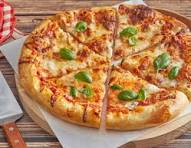

Predicted label: pizza with confidence: 95.68%


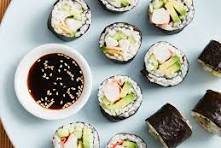

Predicted label: sushi with confidence: 44.91%


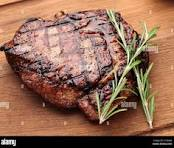

Predicted label: steak with confidence: 81.75%


In [420]:
model_0_predictor = ImagePredictor(model=model1, custom_labels=labels)
create_upload_button(model_0_predictor)

Test acc for each class

In [307]:
import torch
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_class_accuracy(model, data_loader, device='cuda'):
    model = model.to(device)
    model.eval()

    all_true_labels = []
    all_predicted_labels = []

    with torch.inference_mode():
        for inputs, labels in tqdm(data_loader, desc='Calculating Class Accuracy', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            all_true_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(outputs.argmax(dim=1).cpu().numpy())

    precision, recall, f1, _ = precision_recall_fscore_support(
        all_true_labels, all_predicted_labels, average=None, zero_division=0
    )

    class_accuracy = {
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

    return class_accuracy

def train(model, train_data_loader, test_data_loader, optimizer, loss_fn, accuracy_fn,
          epochs=5, early_stop_patience=3, device='cuda'):

    results = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
        'class_accuracy': None
    }

    best_test_loss = float('inf')
    patience_counter = 0

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_data_loader, optimizer, loss_fn, accuracy_fn, device)
        test_loss, test_acc = test_step(model, test_data_loader, loss_fn, accuracy_fn, device)

        print(f"Epoch:{epoch + 1} | Train Loss:{train_loss:.3f} | Train Accuracy:{train_acc:.3f} | Test Loss: {test_loss:.3f}| Test accuracy:{test_acc:.3f}")

        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

        # Early stopping check
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= early_stop_patience:
            print(f"Early stopping at epoch {epoch + 1} due to no improvement in test loss.")
            break

    # Calculate class accuracy
    class_accuracy = calculate_class_accuracy(model, test_data_loader, device)
    results['class_accuracy'] = class_accuracy

    return results


In [308]:
# Assuming you have defined your model, data loaders, optimizer, loss function, and accuracy function

# Set your desired values
epochs = 10
early_stop_patience = 3

# Call the train function
training_results = train(
    model=model1,
    train_data_loader=train_dataloader,
    test_data_loader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    epochs=epochs,
    early_stop_patience=early_stop_patience,
    device='cuda'
)

# Print overall training and test accuracy
print(f"Final Training Accuracy: {training_results['train_acc'][-1]:.3f}")
print(f"Final Test Accuracy: {training_results['test_acc'][-1]:.3f}")

# Print class accuracy metrics
class_accuracy = training_results['class_accuracy']
for i, label in enumerate(labels):
    print(f"Class: {label}")
    print(f"Precision: {class_accuracy['precision'][i]:.3f}")
    print(f"Recall: {class_accuracy['recall'][i]:.3f}")
    print(f"F1 Score: {class_accuracy['f1'][i]:.3f}")
    print("---------------------")


  0%|          | 0/10 [00:03<?, ?it/s]


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same